# Lab 5: Spike Sorting

In this lab, you'll implement a spike sorting algorithm on a synthetic dataset.  

In [2]:
# Import PyTorch modules
import torch
import torch.nn.functional as F

# Plotting stuff
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Some helper utilities
from tqdm.auto import trange
from scipy.signal import find_peaks
from scipy.optimize import linear_sum_assignment

# !pip install neo elephant --quiet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
using_colab = False

In [4]:
if using_colab:
    import sys
    from google.colab import drive
    drive.mount('/content/gdrive/')
    sys.path.append('/content/gdrive/MyDrive/CSE8803_Labs/')
    test_points = torch.load("/content/gdrive/MyDrive/CSE8803_Labs/test_points.pt", map_location=device)
else:
    test_points = torch.load("./test_points.pt", map_location=device)

In [5]:
from utils import generate_syn_sorting, generate_templates, plot_model, plot_templates

## Spike Sorting by Deconvolution

In this part of the lab you'll use those cross-correlation and convolution operations to implement the spike sorting algorithm. We'll apply the algorithm to a synthetic dataset.

Simulating data. This could take a few seconds!


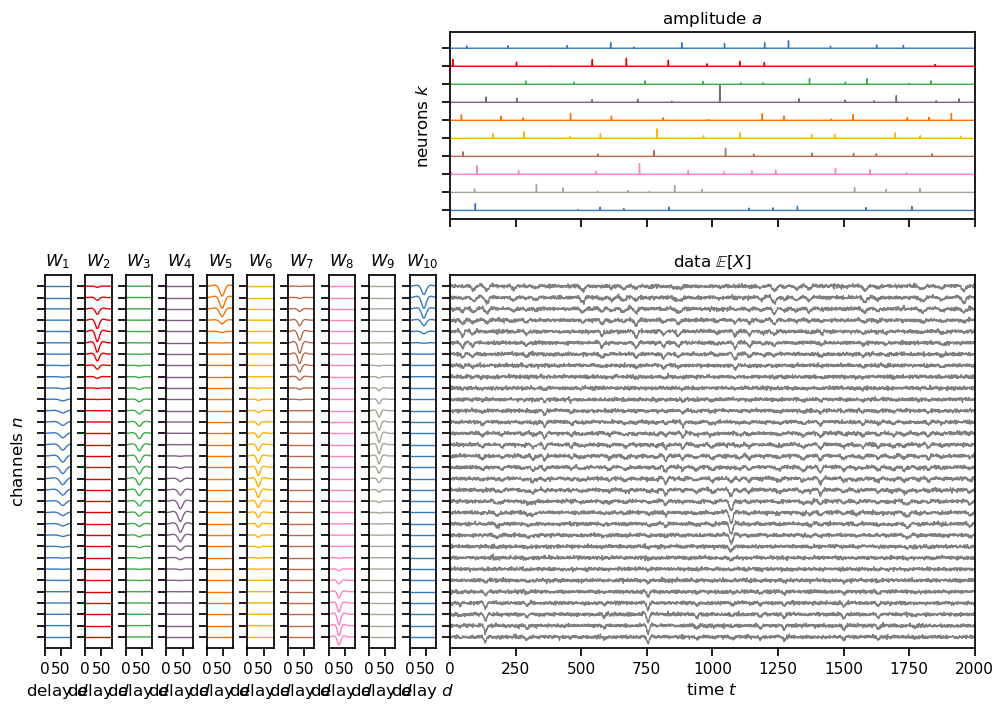

In [6]:
# Create a larger dataset with a multiple channels and neurons.
T = 100000 # number of time samples
N = 32      # number of channels
D = 81      # duration of a spike (in samples)
K = 10      # multiple neurons

# Generate random templates, amplitudes, and noisy data.
# `templates` are NxCxD and `amplitudes` are NxT
torch.manual_seed(0)
print("Simulating data. This could take a few seconds!")
true_templates, true_amplitudes, data = generate_syn_sorting(T, N, D, K)
plot_model(true_templates, true_amplitudes[:, :2000], data[:,:2000], lw=1, figsize=(12, 8))

In [7]:
# Generate another set of random templates and amplitudes to seed the model
torch.manual_seed(1)
templates = generate_templates(N, D, K)
amplitudes = torch.zeros((K, T))
noise_std = 1.0

# Copy the tensors to the GPU (if available)
templates = templates.to(device)
amplitudes = amplitudes.to(device)
data = data.to(device)

### Compute the Log Likelihood

One of the most awesome features of PyTorch is its `torch.distributions` package. See the docs [here](https://pytorch.org/docs/stable/distributions.html). It contains objects for many of our favorite distributions, and has convenient functions for computing log probabilities (with `d.log_prob()` where `d` is a `Distribution` object), sampling (`d.sample()`), computing the entropy (`d.entropy()`), etc. These functions broadcast as you'd expect (unlike `scipy.stats`!), and they're designed to work with automatic differentiation.  More on that another day...

For now, you'll use `MultivariateNormal` to compute the log likelihood of the data given the template and amplitudes, $\log p(\mathbf{X} \mid \mathbf{A}, \mathbf{W})$.  To do that, you'll convolve the amplitudes and templates to get the mean value of $\mathbf{X}$, then you'll use the `log_prob` function to evaluate the likelihood of the data.

In [8]:
templates.shape, amplitudes.shape, data.shape

(torch.Size([10, 32, 81]), torch.Size([10, 100000]), torch.Size([32, 100000]))

In [9]:
templates.permute(1, 0, 2).shape

torch.Size([32, 10, 81])

In [10]:
def log_likelihood(templates, amplitudes, data, noise_std):
    """Evaluate the log likelihood"""
    K, N, D = templates.shape
    _, T = data.shape
    
    # Compute the model prediction by convolving the amplitude and templates
    # new_templates = torch.filp(torch.permute(..., ...), ...)
    # pred = F.conv1d(input=..., weight=...,padding=...)
    # pred = torch.squeeze(pred)
    # dis = torch.distributions.multivariate_normal.MultivariateNormal(...)

    # YOUR CODE HERE
    new_templates = torch.flip(templates.permute(1,0,2), [2])
    pred = F.conv1d(input=amplitudes.unsqueeze(0), weight=new_templates, padding=D-1)
    pred = torch.squeeze(pred)[:, :T].T
    dis = torch.distributions.multivariate_normal.MultivariateNormal(pred, noise_std**2 * torch.eye(N))


    # Evaluate the log probability using dist.Normal
    ll = torch.sum(dis.log_prob(data.T))

    # Return the log probability normalized by the data size
    return ll / (N * T)

In [11]:
# test your answer
ll = log_likelihood(templates, amplitudes, data, noise_std)
assert ll.isclose(test_points["q1"], atol=1e-3)

---

For the following sections, you'll use the `conv1d` function in the `torch.nn.functional` package. We've already imported that package with the shorthand name `F` so that you can call the function with `F.conv1d(...)`. Take a look at its documentation [here](https://pytorch.org/docs/stable/nn.functional.html?highlight=conv1d#torch.nn.functional.conv1d), as well as the corresponding documentation for the `torch.nn.Conv1d` object, which implements a convolutional layer for a neural network. 

**Remember that `conv1d` actually performs a cross-correlation!** 

Let $\mathbf{A} \in \mathbb{R}^{B \times K \times T}$ denote the signal/input and $\mathbf{W} \in \mathbb{R}^{N \times K \times D}$ denote the filter/weights (note that the axes are permuted relative to our mathematical notes), and let $\mathbf{X} \in \mathbb{R}^{B \times N \times T - D + 1}$ denote the output. Then the `conv1d` function implements the cross-correlation, 

$$
\begin{align*}
x_{b,n,t} = \sum_{k = 1}^{K} \sum_{d=1}^D a_{b,k,t+d-1} w_{n,k,d}.
\end{align*}
$$

for $b=1,\ldots,B$, $n=1,\ldots,N$, and $t=1,\ldots,T-D+1$. 

By default the output only contains the "valid" portion of the convolution; i.e. the $T-D+1$ samples where the inputs and weights completely overlap. If you want the "full" output, you have to call `F.conv1d(input, weights, padding=D-1)`. This pads the input with $D-1$ zeros at the beginning and end so that the resulting output is length $T + D - 1$. Depending your application, you may want the first $T$ or the last $T$ entries in this array. When in doubt, try both and see!

Use `conv1d` to implement a 1d **convolution**. Remember that you can do it by cross-correlation as long as you flip your weights along the last axis. 

---

### Compute the residual

Compute the residual for a specified neuron by subtracting the convolved amplitudes and templates for all the other neurons.

In [12]:
templates.shape

torch.Size([10, 32, 81])

In [13]:
def compute_residual(neuron, templates, amplitudes, data):
    K, C, D = templates.shape
    _, T = data.shape
    # Compute the predicted value of the data by 
    # convolving the amplitudes and the templates for all
    # neurons except the specified one.
    
    indexes_without_neuron = torch.cat([torch.arange(neuron), torch.arange(neuron+1, K)])

    # new_templates = torch.filp(torch.permute(..., ...), ...)
    # pred = F.conv1d(input=..., weight=...,padding=...)[:,:,0:T]
    # pred = torch.squeeze(pred)

    # YOUR CODE HERE
    new_templates = torch.flip(templates.permute(1,0,2), [2])[:, indexes_without_neuron]
    pred = F.conv1d(input=amplitudes[indexes_without_neuron].unsqueeze(0), weight=new_templates, padding=D-1)[:, :, 0:T]
    pred = torch.squeeze(pred) 
    # Return the data minus the predicted value given other neurons
    return data - pred

In [14]:
# test your answer
residual = compute_residual(0, templates, amplitudes, data)
assert residual[16, [0, 1234, -1]].allclose(test_points["q2"], atol=1e-4)

### Compute the score

Let the "score" for neuron $k$ be the cross-correlation of the residual and its template. Compute it using `conv1d`.

In [15]:
def compute_score(neuron, templates, amplitudes, data):
    K, N, D = templates.shape
    T = data.shape[1]

    # First get the residual
    residual = compute_residual(neuron, templates, amplitudes, data)

    # score = F.conv1d(input=..., weight=...,padding=...)[:, :, D-1:]

    # YOUR CODE HERE
    score = F.conv1d(input=residual.unsqueeze(0), weight=templates[neuron].unsqueeze(0), padding=D-1)[:, :, D-1:]
        
    return torch.squeeze(score)

In [16]:
# test your answer
score = compute_score(0, templates, amplitudes, data)
assert score[[0, 1234, -1]].allclose(test_points["q3"], atol=1e-4)

### Update the amplitudes using `find_peaks`

Our next step is to update the amplitudes given the scores. We'll use a simple heuristic as described in the course: use `scipy.signal.find_peaks` to find peaks in the score that are separated by a distance of at least $D$ samples and at least a height of $\sigma^2 \lambda$, where $\sigma$ is the standard deviation of the noise and $\lambda$ is the amplitude rate hyperparameter. 

Note that this solution does not guarantee that the resulting nonzero amplitudes will be separated by at least $D$ time steps! In practice, we can enforce this constraint via the following heuristic: after solving for the optimal amplitudes, use the `scipy.signal.find_peaks` function to keep only a subset of nonzero amplitudes that are separated by a distance of $D$

In [17]:
def _update_amplitude(neuron, templates, amplitudes, data, 
                      noise_std=1.0, amp_rate=5.0):
    K, N, D = templates.shape
    T = data.shape[1]

    # Compute the score and convert it to a numpy array.
    score = compute_score(neuron, templates, amplitudes, data).to("cpu")
    
    # Initialize the new amplitudes a_k for this neuron
    new_amplitude = torch.zeros(T, device=device)
    
    # peaks, props = scipy.signal.find_peaks(..., distance=..., height=...)

    # YOUR CODE HERE
    peaks, props = find_peaks(score, distance=D, height=noise_std**2 * amp_rate)


    # Convert the peak heights to a tensor
    heights = torch.tensor(props['peak_heights'], 
                           dtype=torch.float32, device=device)

    # Compute the new amplitude for this neuron.
    new_amplitude[peaks] = heights

    ###
        
    return new_amplitude

In [18]:
# test your anseer
amplitudes[0] = _update_amplitude(0, templates, amplitudes, data)
assert torch.allclose(amplitudes[0][[136, 253, 898, -1]].to("cpu"), 
                      test_points["q4"])

### Update the templates 
Our last step is to update the template for a given neuron by projecting the _target_ $\overline{\mathbf{R}} \in \mathbb{R}^{N \times D}$. The target is the sum of scaled residuals at the times of spikes in the amplitudes:

$$
\begin{align}
    \overline{\mathbf{R}} = \sum_t a_{k,t} \mathbf{R}_{:,t:t+D}.
\end{align}
$$

where $\mathbf{R} \in \mathbb{R}^{N \times T}$ denotes the residual for neuron $n$. 

To get the template, project $\overline{\mathbf{R}}$ onto $\mathcal{S}_K^{(N,D)}$, the set of rank-$K$, unit-norm, $N \times D$ matrices, using the SVD. 

In [29]:
templates.shape

torch.Size([10, 32, 81])

In [63]:
def _update_template(neuron, templates, amplitudes, data, template_rank=1):
    K, N, D = templates.shape
    T = data.shape[1]

    # Initialize the new template
    new_template = torch.zeros((N, D), device=device)

    # Check if the factor is used. If not, generate a random new one.
    if amplitudes[neuron].sum() < 1:
        target = generate_templates(N, D, 1)[0]

    else:
        # Get the residual using the function you wrote above
        residual = compute_residual(neuron, templates, amplitudes, data)

        # Compute the \bar{R} based on the above formula: \bar{R} = \sum_{t}aR
        # bar_R = ...

        # YOUR CODE HERE
        padding_size = D - 1
        padded_residual = F.pad(residual, (0, padding_size))  # Pad only the last dimension (T dimension)
        R_t = torch.stack([padded_residual[:, i:i+D] for i in range(T)], dim=0)
        bar_R = torch.sum(amplitudes[neuron].view(T, 1, 1) * R_t, dim=0)
        target = bar_R
        
    ###
    # Project the target onto the set of normalized rank-K templates using 
    # `torch.linalg.svd` and `torch.linalg.norm`.

    # U, S, VT = torch.linalg.svd(...)
    # S = torch.diag(S)
    # S_K = S[...]
    # S_K_norm = ...
    # new_template = U[...] @ S_K_norm @ VT[...]

    # YOUR CODE HERE
    U, S, VT = torch.linalg.svd(target, full_matrices=False)
    S = torch.diag(S)
    S_K = S[:template_rank, :template_rank]
    S_K_norm = S_K/torch.linalg.norm(S_K)
    new_template = U[:, :template_rank] @ S_K_norm @ VT[:template_rank, :]
    
    return new_template

In [64]:
# test your answer

# Set amplitudes using previous cell output
# so the template update code is executed

templates[0] = _update_template(0, templates, amplitudes, data)
assert torch.linalg.norm(templates[0], 'fro').isclose(
    torch.tensor(1.0), atol=1e-4)
assert templates[0][16, 44].isclose(test_points["q5"], atol=1e-4)

### Put it all together

That's it! We've written a little function to perform coordinate ascent using your `_update_*` functions. It tracks the log likelihood at each iteration. It also uses some nice progress bars so you can see how fast (or slow?) your code runs.

In [65]:
def map_estimate(templates, 
                 amplitudes, 
                 data,
                 num_iters=20, 
                 template_rank=1,
                 noise_std=1.0, 
                 amp_rate=5.0,
                 tol=1e-4):
    """Fit the templates and amplitudes by maximum a posteriori (MAP) estimation
    """
    K, N, D = templates.shape

    # Make fancy reusable progress bars
    outer_pbar = trange(num_iters)
    inner_pbar = trange(K)
    inner_pbar.set_description("updating neurons")

    # Track log likelihoods over iterations
    lls = [log_likelihood(templates, amplitudes, data, noise_std=noise_std)]
    for itr in outer_pbar:
        inner_pbar.reset()
        for k in range(K):
            # Update the amplitude
            amplitudes[k] = _update_amplitude(
                k, templates, amplitudes, data, 
                noise_std=noise_std, amp_rate=amp_rate)    
            # Update the template
            templates[k] = _update_template(
                k, templates, amplitudes, data, template_rank=template_rank)
            inner_pbar.update()

        # Compute the log likelihood 
        lls.append(log_likelihood(templates, amplitudes, data, 
                                  noise_std=noise_std))

        # Check for convergence
        if abs(lls[-1] - lls[-2]) < tol:
            print("Convergence detected!")
            break
    
    return torch.stack(lls)

### Fit the synthetic data and plot the log likelihoods

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Convergence detected!


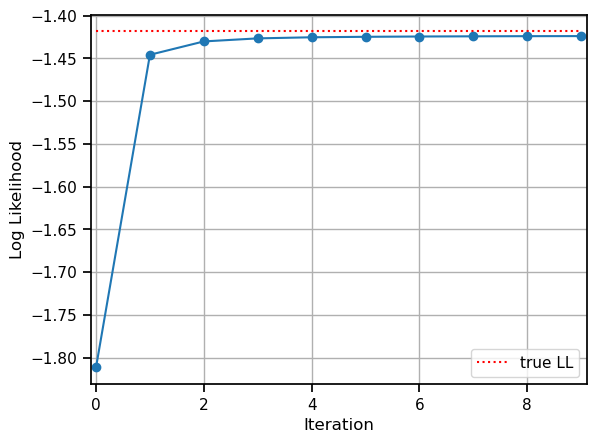

In [66]:
# Make random templates and set amplitude to zero
torch.manual_seed(0)
templates = generate_templates(N, D, K)
amplitudes = torch.zeros((K, T), device=device)
noise_std = 1.0     # \sigma
amp_rate = 5.0      # \lambda

# Copy to the device
true_templates = true_templates.to(device)
true_amplitudes = true_amplitudes.to(device)
templates = templates.to(device)
amplitudes = amplitudes.to(device)
data = data.to(device)

# Fit the model.
lls = map_estimate(templates, amplitudes, data, 
                   noise_std=noise_std, 
                   amp_rate=amp_rate)

# For comparison, compute the log likelihood with the true templates 
# and amplitudes.
true_ll = log_likelihood(true_templates, true_amplitudes, data, noise_std)

# Plot the log likelihoods
lls = lls.to("cpu")
true_ll = true_ll.to("cpu")

plt.plot(lls, '-o')
plt.hlines(true_ll, 0, len(lls) - 1, 
           colors='r', linestyles=':', label="true LL")
plt.xlabel("Iteration")
plt.xlim(-.1, len(lls) - .9)
plt.ylabel("Log Likelihood")
plt.grid(True)
plt.legend(loc="lower right")

### Find a permutation of the inferred neurons that best matches the true neurons

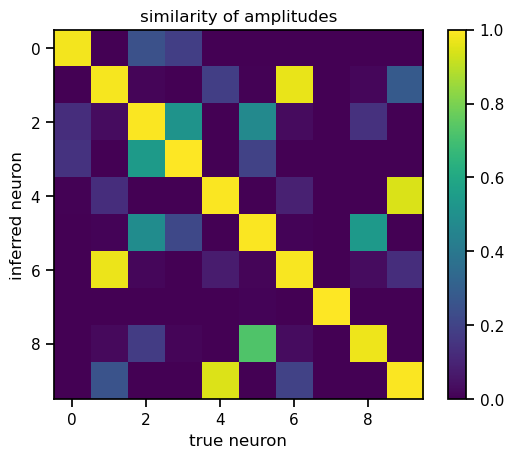

In [67]:
# Compute the similarity (inner product) of the true and inferred templates
similarity = torch.zeros((K, K))
for i in range(K):
    for j in range(K):
        similarity[i, j] = torch.sum(true_templates[i] * templates[j])
        
# Show the similarity matrix
_, perm = linear_sum_assignment(similarity, maximize=True)
plt.imshow(similarity[:, perm], vmin=0, vmax=1)
plt.xlabel("true neuron")
plt.ylabel("inferred neuron")
plt.title("similarity of amplitudes")
plt.colorbar()

### Plot the true and inferred templates

They should line up pretty well.

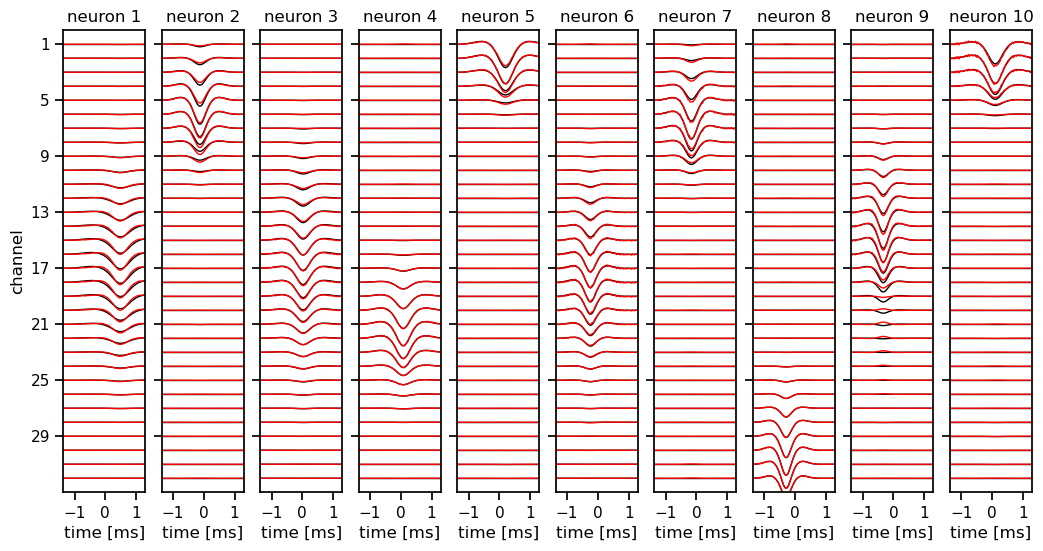

In [68]:
# Plot the true and inferred templates, permuted to best match
fig, axs = plot_templates(true_templates.to("cpu"), torch.arange(K), n_cols=K)
_ = plot_templates(templates[perm].to("cpu"), 
                   torch.arange(K), 
                   n_cols=K, 
                   colors=('r',), 
                   fig=fig, 
                   axs=axs)